In [1]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

os.chdir('/Users/xiaodanxu/Documents/SynthFirm.nosync')

# process TEMPO output

In [5]:
tempo_dir = 'RawData/MOVES/TEMPO-wecc-vintage-class-powertrain-V2.csv'
tempo_fleet = read_csv(tempo_dir)
tempo_fleet.head(5)

,Scenario,Year,Mode,Class,Tech,Vintage,Vehicles
0,base-base,2018,Personal_LDV,Compact,BEV_100,1999,81
1,base-base,2018,Personal_LDV,Compact,BEV_100,2000,770
2,base-base,2018,Personal_LDV,Compact,BEV_100,2001,868
3,base-base,2018,Personal_LDV,Compact,BEV_100,2002,2971
4,base-base,2018,Personal_LDV,Compact,BEV_100,2003,69


In [6]:
tempo_group = {'BEV_100':'Electric',
               'BEV_300':'Electric',
               'FCEV': 'Electric',
               'HEV_Gasoline': 'Gasoline',
               'ICEV_Gasoline': 'Gasoline',
               'ICEV_NG': 'CNG',
               'PHEV_25': 'Gasoline',
               'PHEV_50': 'Gasoline'}

print(tempo_fleet['Tech'].unique())
print(tempo_fleet['Mode'].unique())
selected_year = [2018, 2040]
tempo_fleet.loc[:, 'ageID'] = \
tempo_fleet.loc[:, 'Year'] - tempo_fleet.loc[:, 'Vintage']
tempo_fleet.loc[:, 'fuelID'] = \
tempo_fleet.loc[:, 'Tech'].map(tempo_group)

# drop CNG --> no MOVES ER available
print('the CNG vehicles in tempo:')
print(tempo_fleet.loc[tempo_fleet['fuelID'] == 'CNG', 'Vehicles'].sum())
print('among total vehicles')
print(tempo_fleet['Vehicles'].sum())

# only 0.566%, so drop CNG
tempo_fleet = tempo_fleet.loc[tempo_fleet['fuelID'] != 'CNG']
tempo_fleet.loc[tempo_fleet['ageID']>30, 'ageID'] = 30
tempo_fleet.loc[tempo_fleet['ageID']<0, 'ageID'] = 0
tempo_fleet_selected = \
tempo_fleet.loc[tempo_fleet['Year'].isin(selected_year)]
tempo_fleet_selected = \
tempo_fleet_selected.loc[tempo_fleet_selected['Scenario'] == 'base-base']
tempo_fleet_selected.head(5)

['BEV_100' 'BEV_300' 'FCEV' 'HEV_Gasoline' 'ICEV_Gasoline' 'ICEV_NG'
 'PHEV_25' 'PHEV_50']
['Personal_LDV']
the CNG vehicles in tempo:
296356
among total vehicles
700003287


,Scenario,Year,Mode,Class,Tech,Vintage,Vehicles,ageID,fuelID
0,base-base,2018,Personal_LDV,Compact,BEV_100,1999,81,19,Electric
1,base-base,2018,Personal_LDV,Compact,BEV_100,2000,770,18,Electric
2,base-base,2018,Personal_LDV,Compact,BEV_100,2001,868,17,Electric
3,base-base,2018,Personal_LDV,Compact,BEV_100,2002,2971,16,Electric
4,base-base,2018,Personal_LDV,Compact,BEV_100,2003,69,15,Electric


<Axes: xlabel='ageID', ylabel='Vehicles'>

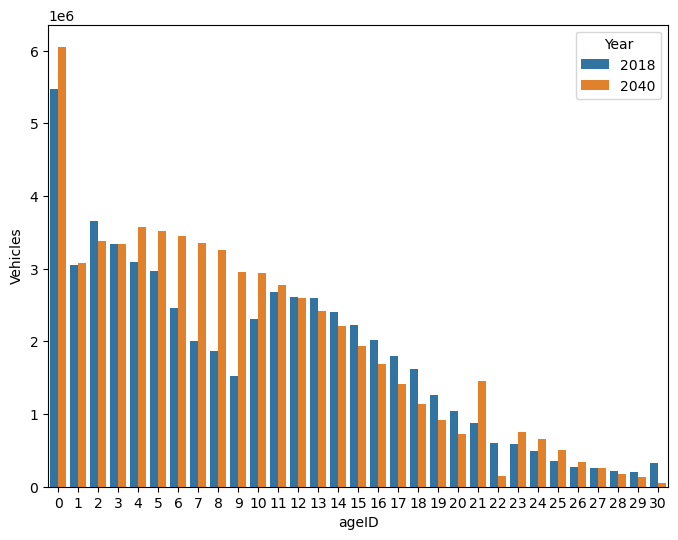

In [7]:
# fleet by age
tempo_fleet_by_age = \
tempo_fleet_selected.groupby(['Year', 'Mode', 'ageID'])[['Vehicles']].sum()
tempo_fleet_by_age = tempo_fleet_by_age.reset_index()
tempo_fleet_by_age.head(5)
plt.figure(figsize = (8,6))
sns.barplot(x = 'ageID', y = 'Vehicles', 
            data = tempo_fleet_by_age, hue = 'Year')

<Figure size 600x500 with 0 Axes>

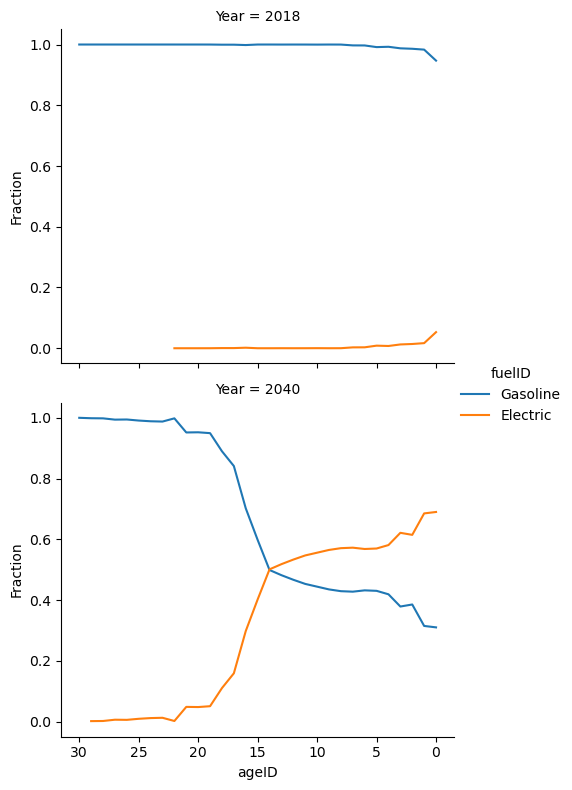

In [8]:
# fraction of fuel by year and vintage
tempo_fleet_by_age_fuel = \
tempo_fleet_selected.groupby(['Year', 'fuelID', 'ageID'])[['Vehicles']].sum()

tempo_fleet_by_age_fuel = tempo_fleet_by_age_fuel.reset_index()
tempo_fleet_by_age_fuel.head(5)
tempo_fleet_by_age_fuel.loc[:, 'Fraction'] = \
tempo_fleet_by_age_fuel.loc[:, 'Vehicles'] /\
tempo_fleet_by_age_fuel.groupby(['Year', 'ageID'])['Vehicles'].transform('sum')

tempo_fleet_by_age_fuel = \
tempo_fleet_by_age_fuel.sort_values(by = 'ageID', ascending = False)
plt.figure(figsize = (6,5))
g = sns.relplot(x = 'ageID', y = 'Fraction', 
            data = tempo_fleet_by_age_fuel, 
            hue = 'fuelID',
            row = 'Year', kind = 'line', height = 4, aspect =1.2)
for ax in g.axes[0]:
    ax.invert_xaxis()

In [9]:
tempo_fleet_by_age_fuel.head(5)

,Year,fuelID,ageID,Vehicles,Fraction
114,2040,Gasoline,30,50746,1.000000
53,2018,Gasoline,30,322949,1.000000
113,2040,Gasoline,29,134437,0.998626
83,2040,Electric,29,185,0.001374
52,2018,Gasoline,29,204813,1.000000


# calculate MOVES avg. emission rate

In [10]:
# load MOVES emission rates
pollutant_lookup = {3: 'NOx', 30: 'NH3', 31:'SO2', 
                    33: 'NO2', 87: 'VOC', 110: 'PM2.5',
                   116: 'PM2.5', 117: 'PM2.5'} # Brake and tire wear
# 1. Emission rate
moveser_2018_dir = 'RawData/MOVES/Seattle_MOVES4_emission_rate_per_mile_2018.csv'
moveser_2040_dir = 'RawData/MOVES/Seattle_MOVES4_emission_rate_per_mile_2040.csv'

moveser_2018 = read_csv(moveser_2018_dir)
moveser_2040 = read_csv(moveser_2040_dir)

moveser_combined = pd.concat([moveser_2018, moveser_2040])
print(moveser_combined.columns)
print(len(moveser_combined))

pollutants = list(pollutant_lookup.keys())
print(pollutants)
moveser_combined = \
moveser_combined.loc[moveser_combined['pollutantID'].isin(pollutants)]
print(len(moveser_combined))
moveser_combined.head(5)

Index(['yearID', 'monthID', 'dayID', 'hourID', 'pollutantID', 'processID',
       'sourceTypeID', 'fuelTypeID', 'modelYearID', 'roadTypeID',
       'avgSpeedBinID', 'temperature', 'relHumidity', 'ratePerDistance'],
      dtype='object')
1283200
[3, 30, 31, 33, 87, 110, 116, 117]
288576


,yearID,monthID,dayID,hourID,pollutantID,processID,sourceTypeID,fuelTypeID,modelYearID,roadTypeID,avgSpeedBinID,temperature,relHumidity,ratePerDistance
388,2018,1,5,8,3,1,21,1,1988,2,1,36.5,85.7,5.06831
389,2018,1,5,8,3,1,31,1,1988,2,1,36.5,85.7,7.85369
390,2018,1,5,8,3,1,21,1,1989,2,1,36.5,85.7,5.06831
391,2018,1,5,8,3,1,31,1,1989,2,1,36.5,85.7,7.85265
392,2018,1,5,8,3,1,21,1,1990,2,1,36.5,85.7,5.52850


In [11]:
# load MOVES VMT factors (road type, speed, source type, model year, RMAR)
path_to_moves = 'RawData/MOVES'

hpms_definition = pd.read_excel(os.path.join(path_to_moves, 'moves_definition.xlsx'), 
                                sheet_name = 'HPMS_definition')
source_type_hpms = pd.read_excel(os.path.join(path_to_moves, 'moves_definition.xlsx'), 
                                sheet_name = 'source_type_HPMS')
source_type_population = pd.read_excel(os.path.join(path_to_moves, 'moves_definition.xlsx'), 
                                sheet_name = 'source_type_population')
age_distribution = pd.read_excel(os.path.join(path_to_moves, 'moves_definition.xlsx'), 
                                sheet_name = 'AGE_distribution')
RMAR_factor = pd.read_excel(os.path.join(path_to_moves, 'moves_definition.xlsx'), 
                                sheet_name = 'RMAR')
road_type_distribution = pd.read_excel(os.path.join(path_to_moves, 'moves_definition.xlsx'), 
                                sheet_name = 'road_type_distribution')
speed_distribution = pd.read_excel(os.path.join(path_to_moves, 'moves_definition.xlsx'), 
                                sheet_name = 'speed_distribution')


# generate VMT distribution by source type and model year
analysis_year = [2018, 2040]

selected_type = [21, 31]

In [12]:
# define source type and model year distribution for average passenger vehicle
# select vehicle composition from the analysis year
source_type_population_year = \
    source_type_population.loc[source_type_population['yearID'].isin(analysis_year)]
# source_type_population_year = \
# source_type_population_year.drop(columns = 'yearID')

source_type_population_year = \
    source_type_population_year.loc[source_type_population_year['sourceTypeID'].isin(selected_type)]
source_type_hpms = \
    source_type_hpms.loc[source_type_hpms['sourceTypeID'].isin(selected_type)]

# select age distribution
age_distribution_year = \
    age_distribution.loc[age_distribution['yearID'].isin(analysis_year)]
age_distribution_year.loc[:, 'modelYearID'] = \
    age_distribution['yearID'] - age_distribution_year.loc[:, 'ageID'] 

# generate VMT fraction by vehicle type and age
fleet_mix_by_hpms = pd.merge(source_type_hpms, hpms_definition,
                              on = 'HPMSVtypeID', how = 'left')
fleet_mix_by_hpms = pd.merge(fleet_mix_by_hpms, source_type_population_year,
                              on = 'sourceTypeID', how = 'left')
fleet_mix_by_hpms = pd.merge(fleet_mix_by_hpms, age_distribution_year,
                              on = ['sourceTypeID', 'yearID'], how = 'left')
# fleet_mix_by_to_check = fleet_mix_by_hpms.loc[fleet_mix_by_hpms['ageID'] == 0]
# fleet_mix_by_to_check
fleet_mix_by_hpms.loc[:, 'population_by_year'] =  \
    fleet_mix_by_hpms.loc[:, 'sourceTypePopulation'] * \
        fleet_mix_by_hpms.loc[:, 'ageFraction']
fleet_mix_by_hpms = pd.merge(fleet_mix_by_hpms, RMAR_factor,
                              on = ['sourceTypeID', 'ageID'], 
                              how = 'left') 
fleet_mix_by_hpms.loc[:, 'weighted_vmt_rate'] =  \
    fleet_mix_by_hpms.loc[:, 'population_by_year'] * \
        fleet_mix_by_hpms.loc[:, 'relativeMAR']
        
fleet_mix_by_hpms.loc[:, 'vmt_fraction'] =  \
    fleet_mix_by_hpms.loc[:, 'weighted_vmt_rate'] / \
        fleet_mix_by_hpms.groupby('yearID')['weighted_vmt_rate'].transform('sum')

fleet_mix_by_hpms = fleet_mix_by_hpms[['yearID',
                                       'sourceTypeID', 
                                        'ageID',
                                        'HPMSVtypeID', 
                                        'sourceTypeName', 
                                        'HPMSVtypeName',
                                        'modelYearID',
                                        'vmt_fraction']]
print(len(fleet_mix_by_hpms))
print(fleet_mix_by_hpms.loc[:, 'vmt_fraction'].sum()) # should be 2
fleet_mix_by_hpms.head(5)

124
2.0


,yearID,sourceTypeID,ageID,HPMSVtypeID,sourceTypeName,HPMSVtypeName,modelYearID,vmt_fraction
0,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.036031
1,2018,21,1,25,Passenger Car,Light Duty Vehicles,2017.0,0.030613
2,2018,21,2,25,Passenger Car,Light Duty Vehicles,2016.0,0.033621
3,2018,21,3,25,Passenger Car,Light Duty Vehicles,2015.0,0.035700
4,2018,21,4,25,Passenger Car,Light Duty Vehicles,2014.0,0.035328


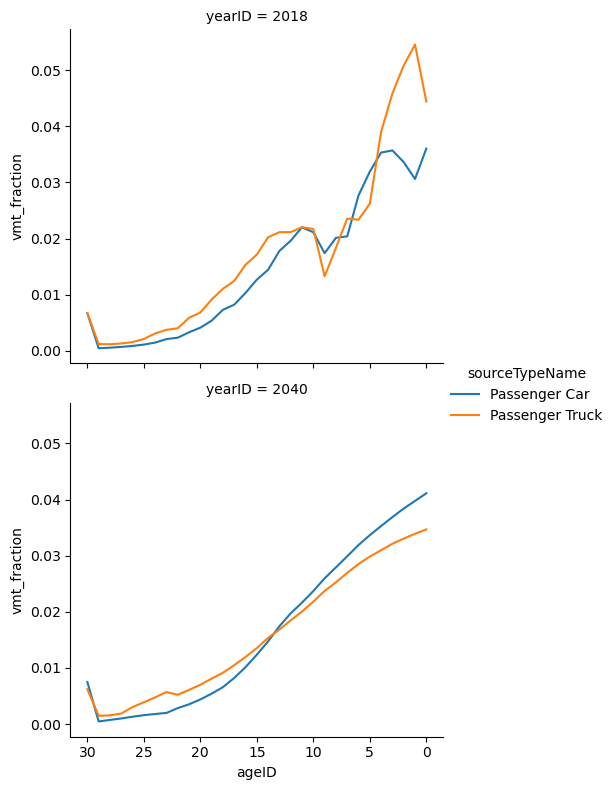

In [13]:
# plot MOVES VMT distribution
# print(len(fleet_mix_by_hpms))
g = sns.relplot(x = 'ageID', y = 'vmt_fraction', 
            data = fleet_mix_by_hpms, 
            hue = 'sourceTypeName',
            row = 'yearID', kind = 'line', height = 4, aspect =1.2)
for ax in g.axes[0]:
    ax.invert_xaxis()

In [14]:
# VMT by speed bin and road type for passenger vehicles
hourDayID = 85 # weekday hour = 8
speed_distribution = \
speed_distribution.loc[speed_distribution['sourceTypeID'].isin(selected_type)]

speed_distribution = \
speed_distribution.loc[speed_distribution['hourDayID'] == hourDayID]

speed_distribution.head(5)

road_type_distribution = \
road_type_distribution.loc[road_type_distribution['roadTypeID'] != 1] 
#drop off-network

speed_road_distribution = pd.merge(speed_distribution,
                                  road_type_distribution,
                                  on = ['sourceTypeID', 'roadTypeID'],
                                  how = 'left')
speed_road_distribution.loc[:, 'op_vmt_fraction'] = \
speed_road_distribution.loc[:, 'avgSpeedFraction'] * \
speed_road_distribution.loc[:, 'roadTypeVMTFraction']

print(len(speed_road_distribution)) # should be 128
print(speed_road_distribution['op_vmt_fraction'].sum()) # should be 2 (source type)
speed_road_distribution = \
speed_road_distribution.drop(columns = ['hourDayID', 'avgSpeedFraction', 'roadTypeVMTFraction'])
speed_road_distribution.head(5)

128
1.9999997671897518


,sourceTypeID,roadTypeID,avgSpeedBinID,op_vmt_fraction
0,21,2,1,0.000339
1,21,2,2,0.000634
2,21,2,3,0.000615
3,21,2,4,0.000474
4,21,2,5,0.000459


In [19]:
# Format TEMPO output and assign fuelTypeID
fuel_id_lookup = {'Gasoline': 1, 'CNG': 3, 'Electric': 9}
tempo_fleet_by_age_fuel.loc[:, 'fuelTypeID'] = \
tempo_fleet_by_age_fuel.loc[:, 'fuelID'].map(fuel_id_lookup)

fuel_type_distribution = \
tempo_fleet_by_age_fuel[['Year', 'ageID', 'fuelTypeID', 'fuelID', 'Fraction']]
fuel_type_distribution.columns = ['yearID', 'ageID', 'fuelTypeID', 'fuelName', 'fuel_fraction']
# fuel_type_distribution.head(5)

fuel_type_to_check = \
fuel_type_distribution.loc[fuel_type_distribution['ageID'] == 0]
fuel_type_to_check

,yearID,ageID,fuelTypeID,fuelName,fuel_fraction
84,2040,0,1,Gasoline,0.310023
54,2040,0,9,Electric,0.689977
23,2018,0,1,Gasoline,0.946979
0,2018,0,9,Electric,0.053021


In [20]:
# assembly all VMT distributioni and assign emission rates
VMT_fraction_combined = pd.merge(fleet_mix_by_hpms, fuel_type_distribution,
                                on = ['yearID', 'ageID'], how = 'left')
print(len(VMT_fraction_combined))
VMT_fraction_combined = pd.merge(VMT_fraction_combined, speed_road_distribution,
                                on = 'sourceTypeID', how = 'left')
print(len(VMT_fraction_combined))
VMT_fraction_combined.loc[:, 'vmt_fraction'] = \
VMT_fraction_combined.loc[:, 'vmt_fraction'] * \
VMT_fraction_combined.loc[:, 'op_vmt_fraction'] * \
VMT_fraction_combined.loc[:, 'fuel_fraction']

print(VMT_fraction_combined.loc[:, 'vmt_fraction'].sum()) # should be 2 (2 years)


# assign MOVES emission rate
var_to_match = ['yearID', 'sourceTypeID', 'fuelTypeID', 'modelYearID', 
                'roadTypeID', 'avgSpeedBinID']
VMT_fraction_with_er = pd.merge(VMT_fraction_combined,
                                moveser_combined,
                                on = var_to_match,
                                how = 'left')
print(len(VMT_fraction_with_er))
# VMT_fraction_combined.head(5)
VMT_fraction_with_er.head(5)

230
14720
1.999999734630213
113664


,yearID,sourceTypeID,ageID,HPMSVtypeID,sourceTypeName,HPMSVtypeName,modelYearID,vmt_fraction,fuelTypeID,fuelName,...,avgSpeedBinID,op_vmt_fraction,monthID,dayID,hourID,pollutantID,processID,temperature,relHumidity,ratePerDistance
0,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,1,0.000339,1.0,5.0,8.0,3.0,1.0,36.5,85.7,0.033871
1,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,1,0.000339,1.0,5.0,8.0,30.0,1.0,36.5,85.7,0.119242
2,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,1,0.000339,1.0,5.0,8.0,31.0,1.0,36.5,85.7,0.016147
3,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,1,0.000339,1.0,5.0,8.0,33.0,1.0,36.5,85.7,0.005284
4,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,1,0.000339,1.0,5.0,8.0,87.0,1.0,36.5,85.7,0.033187


In [17]:
# check fuel split
VMT_fraction_by_fuel = \
VMT_fraction_combined.groupby(['yearID', 'fuelTypeID'] )['vmt_fraction'].sum()
VMT_fraction_by_fuel

yearID  fuelTypeID
2018    1             0.990669
        9             0.009331
2040    1             0.485347
        9             0.514653
Name: vmt_fraction, dtype: float64

In [22]:
# compute final emissions
VMT_fraction_with_er.loc[:, 'emissions'] = \
VMT_fraction_with_er.loc[:, 'ratePerDistance'] * \
VMT_fraction_with_er.loc[:, 'vmt_fraction']

VMT_fraction_with_er.loc[:, 'pollutant'] = \
VMT_fraction_with_er.loc[:, 'pollutantID'].map(pollutant_lookup)
print(VMT_fraction_with_er.columns)
#age bin related
age_bin = [-1, 5, 10, 15, 20, 31]

age_bin_label = ['age<=5', '5<age<=10', '10<age<=15', '15<age<=20', 'age>=20']

VMT_fraction_with_er.loc[:, 'AGE_BIN'] = \
pd.cut(VMT_fraction_with_er.loc[:, 'ageID'], 
       bins=age_bin, right=True, labels=age_bin_label)

VMT_fraction_with_er.head(5)

Index(['yearID', 'sourceTypeID', 'ageID', 'HPMSVtypeID', 'sourceTypeName',
       'HPMSVtypeName', 'modelYearID', 'vmt_fraction', 'fuelTypeID',
       'fuelName', 'fuel_fraction', 'roadTypeID', 'avgSpeedBinID',
       'op_vmt_fraction', 'monthID', 'dayID', 'hourID', 'pollutantID',
       'processID', 'temperature', 'relHumidity', 'ratePerDistance',
       'emissions', 'pollutant'],
      dtype='object')


,yearID,sourceTypeID,ageID,HPMSVtypeID,sourceTypeName,HPMSVtypeName,modelYearID,vmt_fraction,fuelTypeID,fuelName,...,dayID,hourID,pollutantID,processID,temperature,relHumidity,ratePerDistance,emissions,pollutant,AGE_BIN
0,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,5.0,8.0,3.0,1.0,36.5,85.7,0.033871,3.916213e-07,NOx,age<=5
1,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,5.0,8.0,30.0,1.0,36.5,85.7,0.119242,1.378693e-06,NH3,age<=5
2,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,5.0,8.0,31.0,1.0,36.5,85.7,0.016147,1.866962e-07,SO2,age<=5
3,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,5.0,8.0,33.0,1.0,36.5,85.7,0.005284,6.109286e-08,NO2,age<=5
4,2018,21,0,25,Passenger Car,Light Duty Vehicles,2018.0,0.000012,1,Gasoline,...,5.0,8.0,87.0,1.0,36.5,85.7,0.033187,3.837151e-07,VOC,age<=5


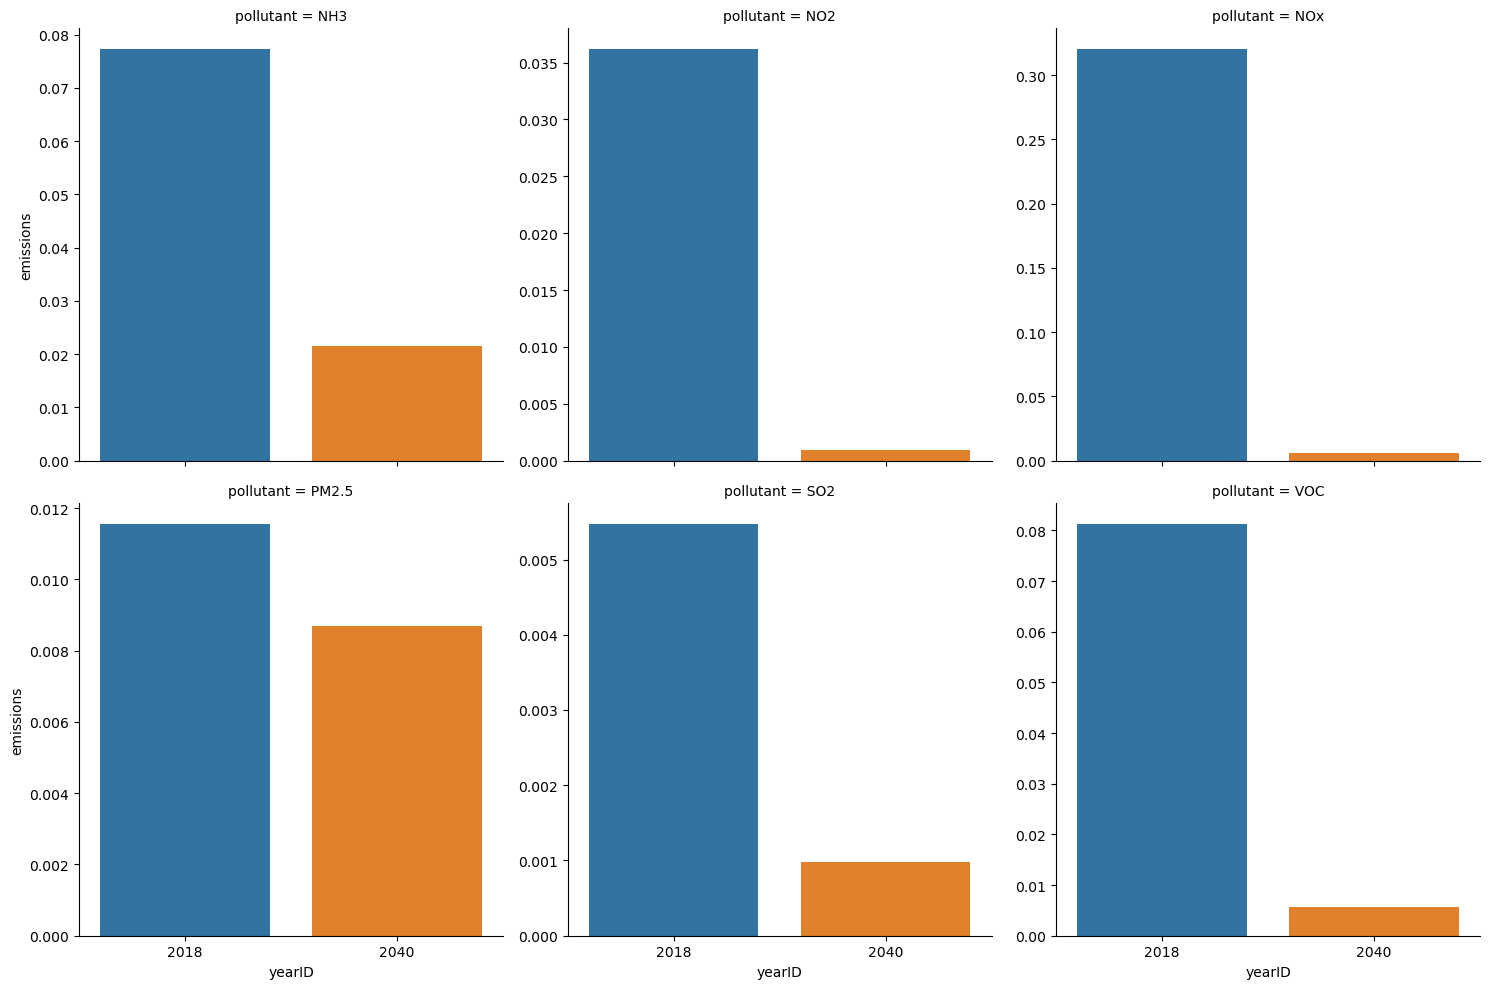

In [26]:
# emission adjustment factor
emission_by_year = \
VMT_fraction_with_er.groupby(['yearID', 'pollutant'])[['emissions']].sum()
emission_by_year = emission_by_year.reset_index()
sns.catplot(emission_by_year, x = 'yearID', y = 'emissions',
           col = 'pollutant', col_wrap =3, sharey = False,
           kind = 'bar')

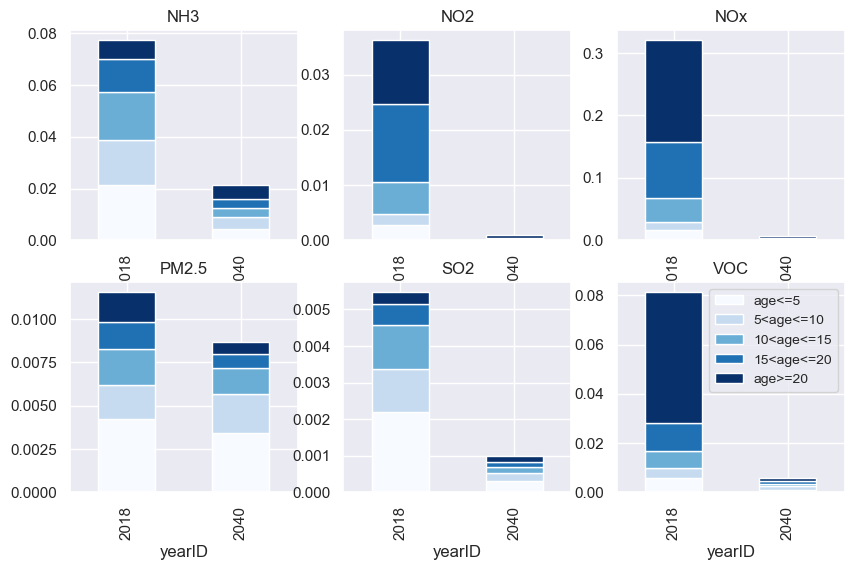

In [53]:
# check breakdowns by age
sns.set_theme(style = "darkgrid")
emission_by_year_age = \
pd.pivot_table(VMT_fraction_with_er, 
               index = ['yearID', 'pollutant'],
               columns = 'AGE_BIN',
               values = 'emissions', aggfunc = 'sum')
emission_by_year_age = emission_by_year_age.reset_index()

#  Categorical Data
a = 2  # number of rows
b = 3  # number of columns
i = 1  # initialize plot counter

fig = plt.figure(figsize = (10,6))
for pol in emission_by_year_age.pollutant.unique():
    ax = plt.subplot(a, b, i)
    emission_to_plot = \
    emission_by_year_age.loc[emission_by_year_age['pollutant'] == pol]

    
    if i == 6:
        emission_to_plot.plot(kind = 'bar', stacked = True, x = 'yearID',
                         cmap= 'Blues', ax = ax)
        plt.title(pol)
        plt.legend(fontsize = 10)
    else:
        emission_to_plot.plot(kind = 'bar', stacked = True, x = 'yearID',
                         cmap= 'Blues', ax = ax, legend = False)
        plt.title(pol)
        # plt.legend(fontsize = 10)        
    i += 1
    # plt.show
    # break
plt.show()

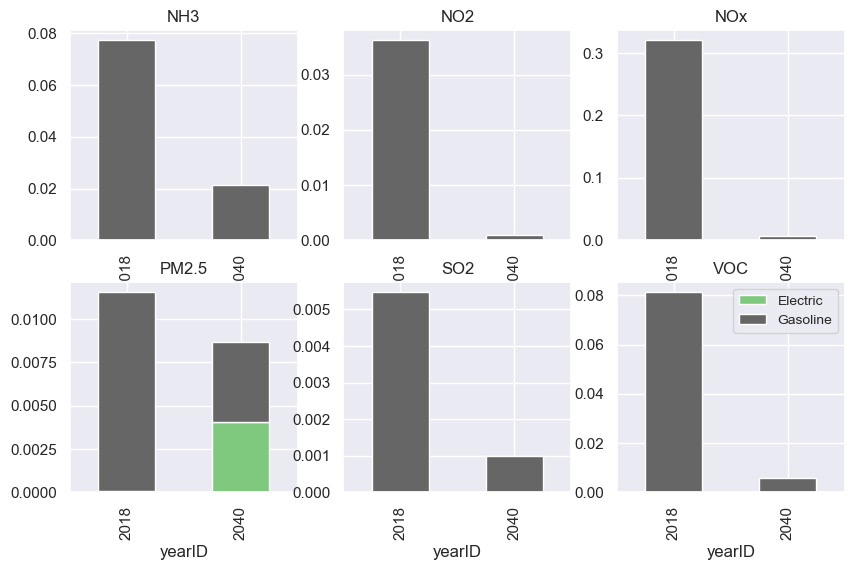

In [52]:
# check breakdowns by fuel
sns.set_theme(style = "darkgrid")
emission_by_year_age = \
pd.pivot_table(VMT_fraction_with_er, 
               index = ['yearID', 'pollutant'],
               columns = 'fuelName',
               values = 'emissions', aggfunc = 'sum')
emission_by_year_age = emission_by_year_age.reset_index()

#  Categorical Data
a = 2  # number of rows
b = 3  # number of columns
i = 1  # initialize plot counter

fig = plt.figure(figsize = (10,6))
for pol in emission_by_year_age.pollutant.unique():
    ax = plt.subplot(a, b, i)
    emission_to_plot = \
    emission_by_year_age.loc[emission_by_year_age['pollutant'] == pol]

    
    if i == 6:
        emission_to_plot.plot(kind = 'bar', stacked = True, x = 'yearID',
                         cmap= 'Accent', ax = ax)
        plt.title(pol)
        plt.legend(fontsize = 10)
    else:
        emission_to_plot.plot(kind = 'bar', stacked = True, x = 'yearID',
                         cmap= 'Accent', ax = ax, legend = False)
        plt.title(pol)
        # plt.legend(fontsize = 10)        
    i += 1
    # plt.show
    # break
plt.show()

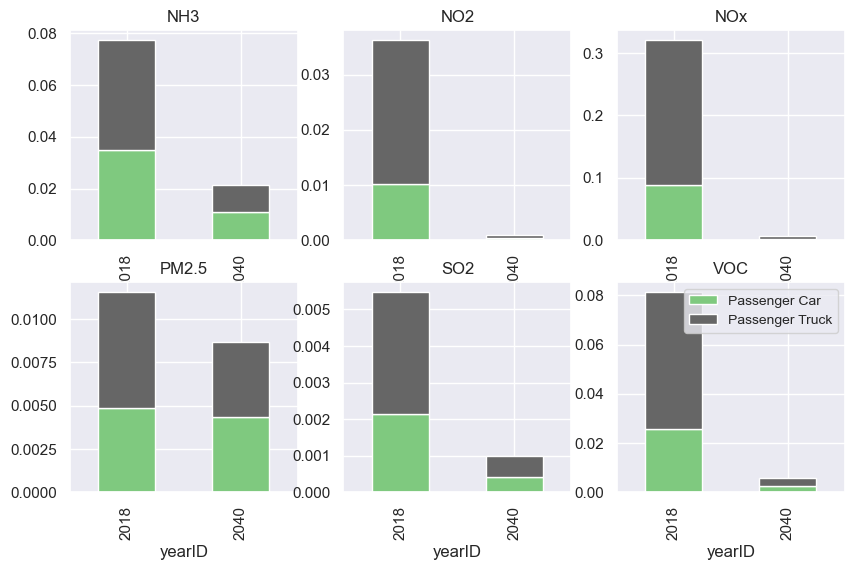

In [48]:
# check breakdowns by TYPE
sns.set_theme(style = "darkgrid")
emission_by_year_age = \
pd.pivot_table(VMT_fraction_with_er, 
               index = ['yearID', 'pollutant'],
               columns = 'sourceTypeName',
               values = 'emissions', aggfunc = 'sum')
emission_by_year_age = emission_by_year_age.reset_index()

#  Categorical Data
a = 2  # number of rows
b = 3  # number of columns
i = 1  # initialize plot counter

fig = plt.figure(figsize = (10,6))
for pol in emission_by_year_age.pollutant.unique():
    ax = plt.subplot(a, b, i)
    emission_to_plot = \
    emission_by_year_age.loc[emission_by_year_age['pollutant'] == pol]

    
    if i == 6:
        emission_to_plot.plot(kind = 'bar', stacked = True, x = 'yearID',
                         cmap= 'Accent', ax = ax)
        plt.title(pol)
        plt.legend(fontsize = 10)
    else:
        emission_to_plot.plot(kind = 'bar', stacked = True, x = 'yearID',
                         cmap= 'Accent', ax = ax, legend = False)
        plt.title(pol)
        # plt.legend(fontsize = 10)        
    i += 1
    # plt.show
    # break
plt.show()

In [47]:
emission_adj_factor = \
pd.pivot_table(VMT_fraction_with_er, 
               index = 'pollutant',
               columns = 'yearID',
               values = 'emissions', aggfunc = 'sum')
emission_adj_factor = emission_adj_factor.reset_index()
emission_adj_factor.columns = ['pollutant', 'em_rate_2018', 'em_rate_2040']
emission_adj_factor.loc[:, 'adj_factor'] = \
emission_adj_factor.loc[:, 'em_rate_2040'] / emission_adj_factor.loc[:, 'em_rate_2018']
emission_adj_factor.to_csv('RawData/MOVES/BILD_AQ_EM_ADJ_FACTOR.csv', index = False)